<a href="https://colab.research.google.com/github/satishchaudhary382/RFM/blob/master/Hull%20MA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [292]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from finta import TA
import ta

In [293]:
df = pd.read_csv("/content/untitled", sep = '\t', parse_dates = ['Date'])

In [294]:
data = df[['Open','High','Low','Close']]
data.columns = ['open','high','low','close']

In [295]:
data['HMA'] = TA.HMA(data)

/usr/local/lib/python3.6/dist-packages/finta/finta.py:315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ohlc["deltawma"] = 2 * wmaf - wmas


In [296]:
df['HMA'] = data.HMA.values

In [297]:
macd = ta.trend.MACD(df.Close)
df['macd'] = macd.macd()
df['macd_signal'] = macd.macd_signal() 

In [298]:
from datetime import timedelta

high_9 = df['High'].rolling(window= 9).max()
low_9 = df['Low'].rolling(window= 9).min()
df['tenkan_sen'] = (high_9 + low_9) /2

high_26 = df['High'].rolling(window= 26).max()
low_26 = df['Low'].rolling(window= 26).min()
df['kijun_sen'] = (high_26 + low_26) /2

# this is to extend the 'df' in future for 26 days
# the 'df' here is numerical indexed df
last_index = df.iloc[-1:].index[0]
last_date = df['Date'].iloc[-1].date()
for i in range(26):
    df.loc[last_index+1 +i, 'Date'] = last_date + timedelta(days=i)

df['senkou_span_a'] = ((df['tenkan_sen'] + df['kijun_sen']) / 2).shift(26)

high_52 = df['High'].rolling(window= 52).max()
low_52 = df['Low'].rolling(window= 52).min()
df['senkou_span_b'] = ((high_52 + low_52) /2).shift(26)

# most charting softwares dont plot this line
df['chikou_span'] = df['Close'].shift(-26) #sometimes -26 

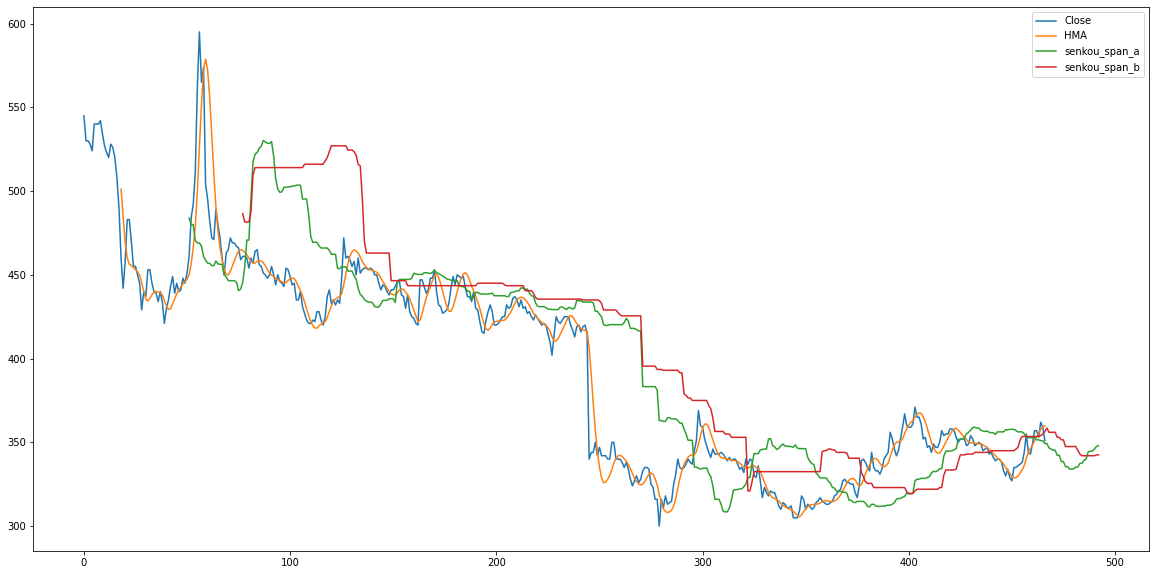

In [299]:
df[['Close','HMA','senkou_span_a','senkou_span_b']].plot(figsize =(20,10))

In [328]:
def senkou_max(df):
  return max(df['senkou_span_a'][:26].values[-1],df['senkou_span_b'][:26].values[-1])
def senkou_min(df):
  return min(df['senkou_span_a'][:26].values[-1],df['senkou_span_b'][:26].values[-1])


In [327]:
df['senkou_span_a'][:26].values[-1]

nan

In [330]:
raw = df.copy()
raw.fillna(0)

,Date,Open,High,Low,Close,Volume,HMA,macd,macd_signal,tenkan_sen,kijun_sen,senkou_span_a,senkou_span_b,chikou_span
0,2017-01-02 00:00:00,545.0,560.0,545.0,545.0,19457.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,450.0
1,2017-01-03 00:00:00,545.0,550.0,530.0,530.0,8202.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,445.0
2,2017-01-04 00:00:00,530.0,535.0,510.0,530.0,6130.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,429.0
3,2017-01-05 00:00:00,530.0,533.0,520.0,528.0,8287.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,440.0
4,2017-01-08 00:00:00,528.0,529.0,520.0,524.0,5593.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,437.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488,2019-01-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,344.75,342.0,0.0
489,2019-01-21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,344.75,342.0,0.0
490,2019-01-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,346.00,342.0,0.0
491,2019-01-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,347.50,342.5,0.0


In [341]:
maximum = []
minimum = []
for i in range(0,len(raw)-26):
  maximum.append(max(raw['senkou_span_a'][26+i],raw['senkou_span_b'][26+i]))

for i in range(0,len(raw)-26):
  minimum.append(min(raw['senkou_span_a'][26+i],raw['senkou_span_b'][26+i]))

for _ in range(26):
  maximum.insert(-1,0)
  minimum.insert(-1,0)

In [342]:
raw['senkou_max'] = maximum
raw['senkou_min'] = minimum

In [346]:
def strategy(raw):
  if (raw['Close'] > raw['HMA']) and (raw['Close']>raw['senkou_max'])  and (raw['macd']>raw['macd_signal']) and (raw['tenkan_sen']>raw['kijun_sen'] or raw['Close']>raw['kijun_sen']):
    return "Long"
  elif (raw['Close'] < raw['HMA']) and (raw['macd']<raw['macd_signal'] or raw['tenkan_sen']<raw['kijun_sen'] or raw['Close']<raw['tenkan_sen'] or raw['Close']<raw['kijun_sen']):
    return "Close long"
  elif (raw['Close']<raw['HMA']) and (raw['Close']<raw['senkou_min']) and (raw['macd']<raw['macd_signal'] or raw['tenkan_sen']<raw['kijun_sen'] or raw['Close']<raw['kijun_sen'] or raw['Close']<raw['tenkan_sen']):
    return "Short"
  elif (raw['Close'] > raw['HMA']) and (raw['macd']>raw['macd_signal'] or raw['tenkan_sen']>raw['kijun_sen'] or raw['Close']>raw['tenkan_sen'] or raw['Close']>raw['kijun_sen']):
    return "Close short"
  else:
    return "Hold" 

In [347]:
raw['Strategy'] = raw.apply(strategy, axis = 1)

In [349]:
for i in range(len(raw)):
  print(f"Date:: {raw.Date[i]} and position :: {raw['Strategy'].values[i]}")

Date:: 2017-01-02 00:00:00 and position :: Hold
Date:: 2017-01-03 00:00:00 and position :: Hold
Date:: 2017-01-04 00:00:00 and position :: Hold
Date:: 2017-01-05 00:00:00 and position :: Hold
Date:: 2017-01-08 00:00:00 and position :: Hold
Date:: 2017-01-09 00:00:00 and position :: Hold
Date:: 2017-01-10 00:00:00 and position :: Hold
Date:: 2017-01-11 00:00:00 and position :: Hold
Date:: 2017-01-12 00:00:00 and position :: Hold
Date:: 2017-01-15 00:00:00 and position :: Hold
Date:: 2017-01-16 00:00:00 and position :: Hold
Date:: 2017-01-17 00:00:00 and position :: Hold
Date:: 2017-01-18 00:00:00 and position :: Hold
Date:: 2017-01-19 00:00:00 and position :: Hold
Date:: 2017-01-22 00:00:00 and position :: Hold
Date:: 2017-01-23 00:00:00 and position :: Hold
Date:: 2017-01-24 00:00:00 and position :: Hold
Date:: 2017-01-25 00:00:00 and position :: Hold
Date:: 2017-01-26 00:00:00 and position :: Close long
Date:: 2017-01-30 00:00:00 and position :: Close long
Date:: 2017-01-31 00:00:00 a

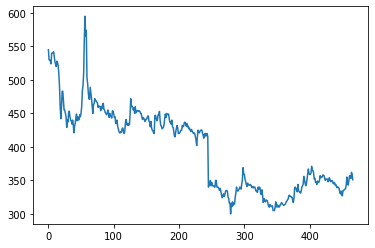

In [350]:
plt.plot(df.Close)